In [38]:
import torch
from torchvision.datasets import MNIST

In [39]:
dataset = MNIST("data/", train=True, download=True)

In [40]:
test_dataset = MNIST("data/", train=False)

In [41]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/
    Split: Train

In [42]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: data/
    Split: Test

In [43]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7FD8AA56C610>, 5)

Label: 5


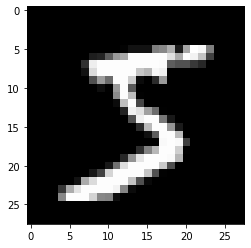

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

image, label = dataset[0]
plt.imshow(image, cmap="gray")
print("Label:", label)

## Load Dataset as PyTorch Tensors

In [45]:
import torchvision.transforms as transforms

dataset = MNIST("data/", train=True, transform=transforms.ToTensor())
test_dataset = MNIST("data/", train=False, transform=transforms.ToTensor())

img_tensor, label = dataset[0]
img_tensor.shape, label

(torch.Size([1, 28, 28]), 5)

## Training and Validation Datasets, Dataloader

In [46]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

train_ds, val_ds = random_split(dataset, [50_000, 10_000])

len(train_ds), len(val_ds)

(50000, 10000)

In [47]:
BATCH_SIZE = 128

train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, BATCH_SIZE, shuffle=True)

test_dl = DataLoader(test_dataset, BATCH_SIZE*2)

## Model

In [48]:
def accuracy(preds, labels):
  _, preds = torch.max(preds, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [49]:
def evaluate(model, val_loader):
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

In [57]:
import torch.nn as nn
import torch.nn.functional as F

input_size = 28*28
num_classes = 10

class MNISTModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(input_size, num_classes)

  def forward(self, xb):
    xb = xb.reshape(-1, 784)
    out = self.linear(xb)
    return out

  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    # with torch.no_grad():
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {"val_loss": loss, "val_acc": acc}

  def validation_epoch_end(self, outputs):
    # with torch.no_grad():
    batch_losses = [x["val_loss"] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x["val_acc"] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], Val_Loss: {}, Val_Acc: {}".format(epoch, result["val_loss"], result["val_acc"]))
  

model = MNISTModel()

In [58]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  optimizer = opt_func(model.parameters(), lr)
  history = []

  for epoch in range(epochs):
    # Training Phase

    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    # Validation Step
    result = evaluate(model, val_loader)
    model.epoch_end(epoch, result)
    history.append(result)

  return history

In [59]:
result0 = evaluate(model, val_dl)
result0

{'val_acc': 0.12905459105968475, 'val_loss': 2.2993619441986084}

In [60]:
history1 = fit(5, 0.001, model, train_dl, val_dl)

Epoch [0], Val_Loss: 1.9310557842254639, Val_Acc: 0.6527887582778931
Epoch [1], Val_Loss: 1.661705493927002, Val_Acc: 0.7398141026496887
Epoch [2], Val_Loss: 1.4586631059646606, Val_Acc: 0.7723496556282043
Epoch [3], Val_Loss: 1.3097500801086426, Val_Acc: 0.7879746556282043
Epoch [4], Val_Loss: 1.1956652402877808, Val_Acc: 0.7993472814559937


In [61]:
history2 = fit(5, 0.001, model, train_dl, val_dl)

Epoch [0], Val_Loss: 1.1030586957931519, Val_Acc: 0.8082476258277893
Epoch [1], Val_Loss: 1.0299943685531616, Val_Acc: 0.8152689933776855
Epoch [2], Val_Loss: 0.9748060703277588, Val_Acc: 0.8183346390724182
Epoch [3], Val_Loss: 0.9242633581161499, Val_Acc: 0.8232792615890503
Epoch [4], Val_Loss: 0.8797768950462341, Val_Acc: 0.8289161324501038


In [62]:
history3 = fit(5, 0.001, model, train_dl, val_dl)

Epoch [0], Val_Loss: 0.840535044670105, Val_Acc: 0.832772970199585
Epoch [1], Val_Loss: 0.8139718174934387, Val_Acc: 0.8325751423835754
Epoch [2], Val_Loss: 0.785693883895874, Val_Acc: 0.8364319801330566
Epoch [3], Val_Loss: 0.760574460029602, Val_Acc: 0.8398932218551636
Epoch [4], Val_Loss: 0.7377579808235168, Val_Acc: 0.8421677350997925


In [63]:
history4 = fit(5, 0.001, model, train_dl, val_dl)

Epoch [0], Val_Loss: 0.7202978134155273, Val_Acc: 0.8453322649002075
Epoch [1], Val_Loss: 0.7029852271080017, Val_Acc: 0.8482001423835754
Epoch [2], Val_Loss: 0.6861676573753357, Val_Acc: 0.8499802350997925
Epoch [3], Val_Loss: 0.672236979007721, Val_Acc: 0.8515625
Epoch [4], Val_Loss: 0.6609001755714417, Val_Acc: 0.8526503443717957


Text(0.5, 1.0, 'Accuracy Vs Epochs')

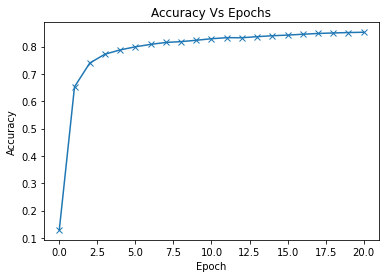

In [64]:
history = [result0] + history1 + history2 + history3 + history4
accuracies = [x["val_acc"] for x in history]
plt.plot(accuracies, "-x")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Vs Epochs")

### Inspect

In [65]:
def predict(image_tensor, model):
  xb = image_tensor.unsqueeze(0)
  yb = model(xb)
  _, preds = torch.max(yb, dim=1)
  return preds[0].item()

Label: 7 Predicted: 7


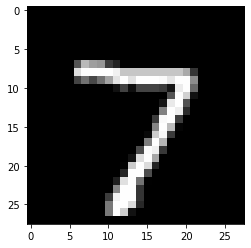

In [76]:
indices = [0, 10, 100, 200, 500, 1001, 2002, 5000, 7000, 9000]


img, label = test_dataset[0]
plt.imshow(img[0], cmap="gray")
print("Label: {} Predicted: {}".format(label, predict(img, model)))

Label: 0 Predicted: 0


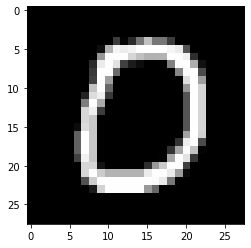

In [77]:
img, label = test_dataset[10]
plt.imshow(img[0], cmap="gray")
print("Label: {} Predicted: {}".format(label, predict(img, model)))

Label: 6 Predicted: 6


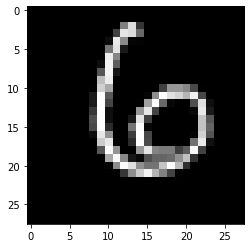

In [78]:
img, label = test_dataset[100]
plt.imshow(img[0], cmap="gray")
print("Label: {} Predicted: {}".format(label, predict(img, model)))

Label: 3 Predicted: 3


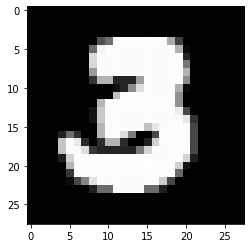

In [79]:
img, label = test_dataset[200]
plt.imshow(img[0], cmap="gray")
print("Label: {} Predicted: {}".format(label, predict(img, model)))

### Test Accuracy

In [80]:
evaluate(model, test_dl)

{'val_acc': 0.8623046875, 'val_loss': 0.6393201351165771}

### Saving and Loading the Model

In [81]:
torch.save(model.state_dict(), "mnist_model.pth")

In [82]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0329, -0.0092,  0.0026,  ..., -0.0221,  0.0121,  0.0344],
                      [ 0.0092, -0.0145, -0.0238,  ..., -0.0297, -0.0069,  0.0352],
                      [-0.0117,  0.0074,  0.0184,  ...,  0.0228,  0.0217,  0.0019],
                      ...,
                      [ 0.0338,  0.0233,  0.0337,  ...,  0.0137, -0.0260, -0.0075],
                      [-0.0210,  0.0238,  0.0144,  ..., -0.0353, -0.0131, -0.0065],
                      [ 0.0222, -0.0078, -0.0153,  ..., -0.0147,  0.0291,  0.0102]])),
             ('linear.bias',
              tensor([-0.0342,  0.0857, -0.0268, -0.0282,  0.0619,  0.0379,  0.0135,  0.0400,
                      -0.0928, -0.0254]))])

In [84]:
model = MNISTModel()
model.load_state_dict(torch.load("mnist_model.pth"))

<All keys matched successfully>

In [85]:
evaluate(model, test_dl)

{'val_acc': 0.8623046875, 'val_loss': 0.6393201351165771}